In [3]:
from backtests import backtest_Lasso, backtest_XGBoost, backtest_OLS
import datetime as dt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings

from tqdm.auto import tqdm
from IPython.display import clear_output

warnings.filterwarnings('ignore')

c:\Users\mikol\Desktop\Master thesis\mcut_feature_selection\mcut_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_pickle('data/broaded_df').dropna()
train = df.loc['2021':'2022'].copy()
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std * 100
train['marg'] = pd.read_pickle('data/broaded_df').dropna().loc['2021':'2022'].marg


test = df.loc['2023':'2023-3'].copy()
test = (test - train_mean) / train_std * 100
test['marg'] = pd.read_pickle('data/broaded_df').dropna().loc['2023':'2023-3'].marg

nan_cols = list(set(test.isna().sum()[test.isna().sum()>1000].index.tolist() + train.isna().sum()[train.isna().sum()>1000].index.tolist()))

train = train.drop(columns=nan_cols).dropna()
test = test.drop(columns=nan_cols).dropna()


In [5]:
df = pd.concat([train, test]).sort_index()

In [6]:
strategy2backtest = {
    backtest_Lasso: 'lasso_feature_selection',
    backtest_OLS: ['correlation_features', 'RFE_feature_selection', 'sequential_feature_selection', 'relief_algorithm', 'mcut_feature_selection'],
    backtest_XGBoost: 'xgboost_feature_selection'
}

backtest2strategy = {
    'lasso_feature_selection': backtest_Lasso,
    'correlation_features': backtest_OLS,
    'RFE_feature_selection': backtest_OLS,
    'sequential_feature_selection': backtest_OLS,
    'relief_algorithm': backtest_OLS,
    'mcut_feature_selection': backtest_OLS,
    'xgboost_feature_selection': backtest_XGBoost
}


In [7]:

def mean_std(x):
    x = x.copy()
    """Function to calculate mean to std ratio"""
    if np.std(x) == 0:
        return 0
    x = x.copy()
    return np.mean(x) / np.std(x)

def winrate(x):
    x = x.copy()
    return x[x>0].shape[0]/x.shape[0]

In [10]:
import os
pnls = {}
res = pd.DataFrame(columns=['strategy', 'mean', 'count', 'sum', 'winrate', 'mean_std'])
for strat in ['lasso_feature_selection','correlation_features', 'RFE_feature_selection', 'sequential_feature_selection', 'relief_algorithm', 'mcut_feature_selection','xgboost_feature_selection']:
    for sub_results in [name for name in os.listdir('data') if (strat in name) & ('std' in name) ]:
        print(sub_results)
        data = df.copy()
        d, pvs = backtest2strategy[strat](data, pd.read_pickle(f'data/{sub_results}')[:-1], 'train')
        pnl = (np.sign(d.pred) * d.marg).dropna()
        res.loc[sub_results] = [strat, pnl.mean(), pnl.count(), pnl.sum(), winrate(pnl), mean_std(pnl)]
        pnls[sub_results] = pnl
        clear_output()  

In [11]:
# res.to_pickle('data/experiment_5_results_std_train.pkl')

In [8]:
res = pd.read_pickle('data/experiment_5_results_std_train.pkl')

In [9]:
# save pnls to pickle
# import pickle
# with open('data/experiment_5_pnls_std_train.pkl', 'wb') as f:
#     pickle.dump(pnls, f)

In [14]:
pnls = pd.read_pickle('data/experiment_5_pnls_std_train.pkl')

In [17]:
pnls.keys()

dict_keys(['std_lasso_feature_selection_0.1.pkl', 'std_lasso_feature_selection_0.5.pkl', 'std_lasso_feature_selection_1.pkl', 'std_lasso_feature_selection_10.pkl', 'std_lasso_feature_selection_5.pkl', 'std_correlation_features_10.pkl', 'std_correlation_features_15.pkl', 'std_correlation_features_20.pkl', 'std_correlation_features_25.pkl', 'std_correlation_features_5.pkl', 'std_RFE_feature_selection_10.pkl', 'std_RFE_feature_selection_15.pkl', 'std_RFE_feature_selection_20.pkl', 'std_RFE_feature_selection_25.pkl', 'std_RFE_feature_selection_5.pkl', 'std_sequential_feature_selection_10.pkl', 'std_sequential_feature_selection_15.pkl', 'std_sequential_feature_selection_20.pkl', 'std_sequential_feature_selection_25.pkl', 'std_sequential_feature_selection_5.pkl', 'std_relief_algorithm_10.pkl', 'std_relief_algorithm_15.pkl', 'std_relief_algorithm_20.pkl', 'std_relief_algorithm_25.pkl', 'std_relief_algorithm_5.pkl', 'std_mcut_feature_selection_100.pkl', 'std_mcut_feature_selection_125.pkl', 's

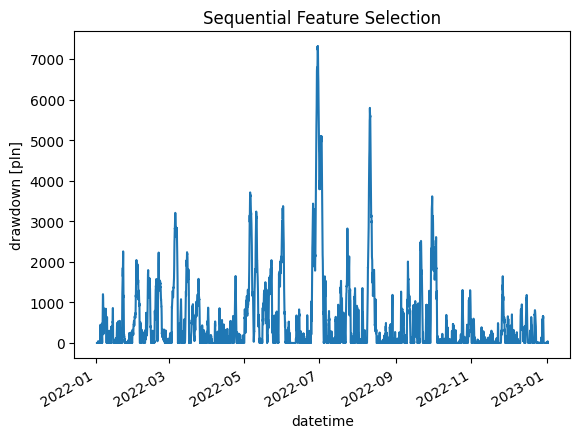

In [18]:
(pnls['std_sequential_feature_selection_25.pkl'].cumsum().cummax() - pnls['std_sequential_feature_selection_25.pkl'].cumsum()).plot()
plt.title('Sequential Feature Selection')
plt.ylabel('drawdown [pln]')
plt.xlabel('datetime')
plt.savefig('charts/exp5_seq_std_drawdowns.png')

In [10]:
results = res.round(2).sort_values(['mean_std', 'winrate'])

In [9]:
results.groupby('strategy').apply(lambda x: x[(x['mean_std']==x['mean_std'].max())]).sort_values(['winrate', 'sum'], ascending=False).reset_index(drop=True).groupby('strategy').head(1).reset_index(drop=1)

,strategy,mean,count,sum,winrate,mean_std
0,sequential_feature_selection,34.25,8759,300021.28,0.65,0.35
1,relief_algorithm,26.06,8759,228253.82,0.62,0.26
2,mcut_feature_selection,22.78,8759,199561.92,0.60,0.22
3,correlation_features,22.72,8759,198970.92,0.60,0.22
4,xgboost_feature_selection,18.31,8759,160374.12,0.59,0.18
5,lasso_feature_selection,15.91,8759,139359.46,0.57,0.15
6,RFE_feature_selection,12.15,8759,106419.04,0.55,0.12


In [15]:
results.groupby('strategy').apply(lambda x: x[(x['mean_std']==x['mean_std'].max())])


strategy  \
strategy                                                                                             
RFE_feature_selection        std_RFE_feature_selection_5.pkl                 RFE_feature_selection   
correlation_features         std_correlation_features_10.pkl                  correlation_features   
                             std_correlation_features_5.pkl                   correlation_features   
lasso_feature_selection      std_lasso_feature_selection_10.pkl            lasso_feature_selection   
mcut_feature_selection       std_mcut_feature_selection_100.pkl             mcut_feature_selection   
                             std_mcut_feature_selection_125.pkl             mcut_feature_selection   
                             std_mcut_feature_selection_150.pkl             mcut_feature_selection   
                             std_mcut_feature_selection_50.pkl              mcut_feature_selection   
                             std_mcut_feature_selection_75.pkl              mcut_feature_selection   
relief_algorithm             std_relief_algorithm_25.pkl                          relief_algorithm   
sequential_feature_selection std_sequential_feature_selection_25.pkl  sequential_feature_selection   
xgboost_feature_selection    std_xgboost_feature_selection_15.pkl        xgboost_feature_selection   
                             std_xgboost_feature_selection_25.pkl        xgboost_feature_selection   

                                                                       mean  \
strategy                                                                      
RFE_feature_selection        std_RFE_feature_selection_5.pkl          12.15   
correlation_features         std_correlation_features_10.pkl          22.04   
                             std_correlation_features_5.pkl           22.72   
lasso_feature_selection      std_lasso_feature_selection_10.pkl       15.91   
mcut_feature_selection       std_mcut_feature_selection_100.pkl       22.78   
                             std_mcut_feature_selection_125.pkl       22.78   
                             std_mcut_feature_selection_150.pkl       22.78   
                             std_mcut_feature_selection_50.pkl        22.78   
                             std_mcut_feature_selection_75.pkl        22.78   
relief_algorithm             std_relief_algorithm_25.pkl              26.06   
sequential_feature_selection std_sequential_feature_selection_25.pkl  34.25   
xgboost_feature_selection    std_xgboost_feature_selection_15.pkl     18.36   
                             std_xgboost_feature_selection_25.pkl     18.31   

                                                                      count  \
strategy                                                                      
RFE_feature_selection        std_RFE_feature_selection_5.pkl           8759   
correlation_features         std_correlation_features_10.pkl           8759   
                             std_correlation_features_5.pkl            8759   
lasso_feature_selection      std_lasso_feature_selection_10.pkl        8759   
mcut_feature_selection       std_mcut_feature_selection_100.pkl        8759   
                             std_mcut_feature_selection_125.pkl        8759   
                             std_mcut_feature_selection_150.pkl        8759   
                             std_mcut_feature_selection_50.pkl         8759   
                             std_mcut_feature_selection_75.pkl         8759   
relief_algorithm             std_relief_algorithm_25.pkl               8759   
sequential_feature_selection std_sequential_feature_selection_25.pkl   8759   
xgboost_feature_selection    std_xgboost_feature_selection_15.pkl      8759   
                             std_xgboost_feature_selection_25.pkl      8759   

                                                                            sum  \
strategy                                                                          
RFE_feature_selection

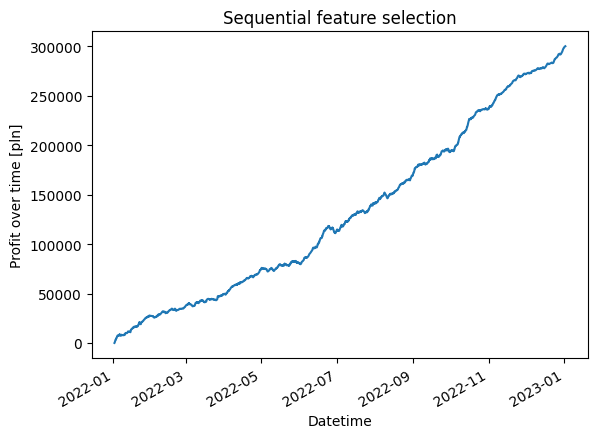

In [16]:
import matplotlib.pyplot as plt
pnls['std_sequential_feature_selection_25.pkl'].cumsum().plot()
plt.title('Sequential feature selection')
plt.xlabel('Datetime')
plt.ylabel('Profit over time [pln]')
plt.savefig('charts\exp5_std_sequential_feature_selection_25.png', format='png')

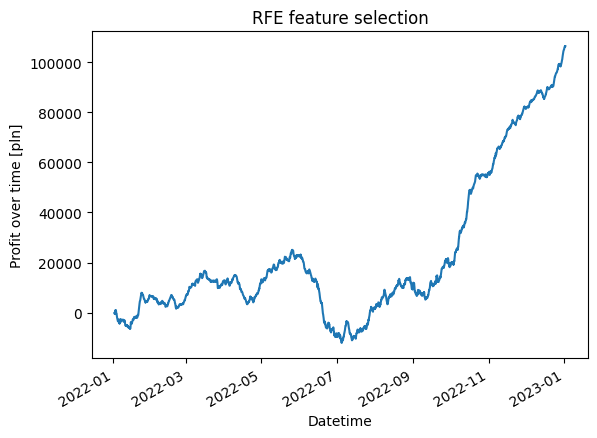

In [17]:
import matplotlib.pyplot as plt
pnls['std_RFE_feature_selection_5.pkl'].cumsum().plot()
plt.title('RFE feature selection')
plt.xlabel('Datetime')
plt.ylabel('Profit over time [pln]')
plt.savefig('charts\exp5_std_RFE_feature_selection_5.png', format='png')

In [11]:
res2 = pd.DataFrame(columns=['strategy', 'mean', 'count', 'sum', 'winrate', 'mean_std'])
pnls = {}
for hiperparams_version, strategy in (results.groupby('strategy').tail(1)[['strategy']]).iterrows():
    strat = strategy.values[0]
    data = df.copy()
    d, pvs = backtest2strategy[strat](data, pd.read_pickle(f'data/{hiperparams_version}')[:-1], 'test')
    pnl = (np.sign(d.pred) * d.marg).dropna()
    res2.loc[hiperparams_version] = [strat, pnl.mean(), pnl.count(), pnl.sum(), winrate(pnl), mean_std(pnl)]
    pnls[strat] = pnl
    clear_output()  
        
        
        

In [12]:
res2.groupby('strategy').apply(lambda x: x[(x['mean_std']==x['mean_std'].max())]).sort_values(['mean_std', 'winrate'], ascending=False).reset_index(drop=True).groupby('strategy').head(1).reset_index(drop=1)

,strategy,mean,count,sum,winrate,mean_std
0,RFE_feature_selection,3.469393,2159,7490.42,0.496526,0.048684
1,sequential_feature_selection,2.299324,2159,4964.24,0.511348,0.032244
2,relief_algorithm,1.657601,2159,3578.76,0.517369,0.023239
3,xgboost_feature_selection,-1.149801,2159,-2482.42,0.491431,-0.016117
4,lasso_feature_selection,-1.901315,2159,-4104.94,0.477073,-0.026658
5,mcut_feature_selection,-6.251598,2159,-13497.20,0.491431,-0.087960
6,correlation_features,-6.791672,2159,-14663.22,0.490505,-0.095625


In [12]:
res2

,strategy,mean,count,sum,winrate,mean_std
std_RFE_feature_selection_5.pkl,RFE_feature_selection,3.469393,2159,7490.42,0.496526,0.048684
std_lasso_feature_selection_10.pkl,lasso_feature_selection,-1.901315,2159,-4104.94,0.477073,-0.026658
std_xgboost_feature_selection_25.pkl,xgboost_feature_selection,-1.149801,2159,-2482.42,0.491431,-0.016117
std_correlation_features_5.pkl,correlation_features,-6.791672,2159,-14663.22,0.490505,-0.095625
std_mcut_feature_selection_75.pkl,mcut_feature_selection,-6.251598,2159,-13497.20,0.491431,-0.087960
std_relief_algorithm_25.pkl,relief_algorithm,1.657601,2159,3578.76,0.517369,0.023239
std_sequential_feature_selection_25.pkl,sequential_feature_selection,2.299324,2159,4964.24,0.511348,0.032244


In [20]:
res2

,strategy,mean,count,sum,winrate,mean_std
std_RFE_feature_selection_5.pkl,RFE_feature_selection,3.469393,2159,7490.42,0.496526,0.048684
std_lasso_feature_selection_10.pkl,lasso_feature_selection,-1.901315,2159,-4104.94,0.477073,-0.026658
std_xgboost_feature_selection_25.pkl,xgboost_feature_selection,-1.149801,2159,-2482.42,0.491431,-0.016117
std_correlation_features_5.pkl,correlation_features,-6.791672,2159,-14663.22,0.490505,-0.095625
std_mcut_feature_selection_75.pkl,mcut_feature_selection,-6.251598,2159,-13497.20,0.491431,-0.087960
std_relief_algorithm_25.pkl,relief_algorithm,1.657601,2159,3578.76,0.517369,0.023239
std_sequential_feature_selection_25.pkl,sequential_feature_selection,2.299324,2159,4964.24,0.511348,0.032244


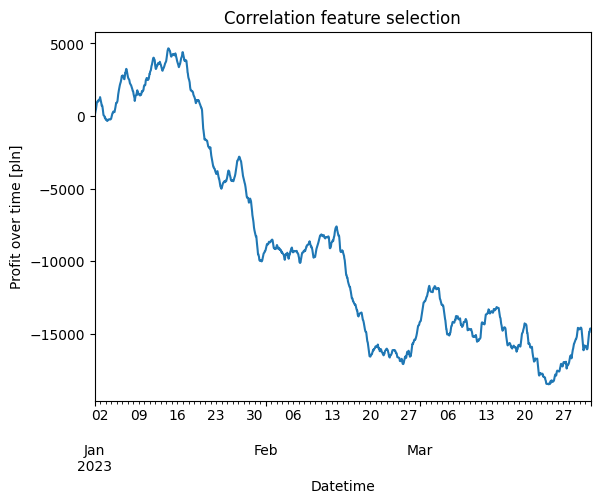

In [13]:
import matplotlib.pyplot as plt
pnls['correlation_features'].cumsum().plot()
plt.title('Correlation feature selection')
plt.xlabel('Datetime')
plt.ylabel('Profit over time [pln]')
plt.savefig('charts\exp5_test_std_std_correlation_features_5.png', format='png')

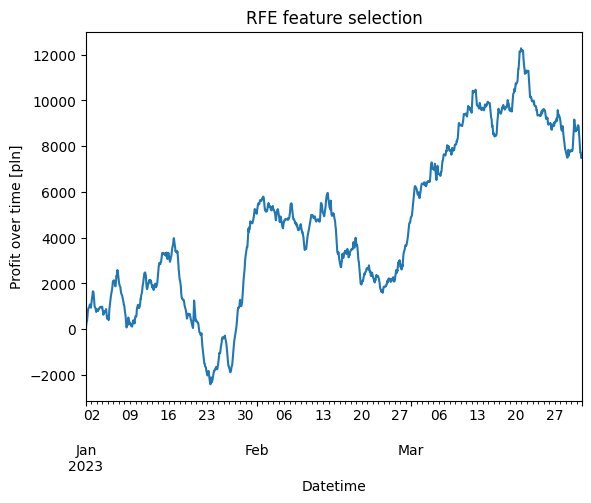

In [21]:
import matplotlib.pyplot as plt
pnls['RFE_feature_selection'].cumsum().plot()
plt.title('RFE feature selection')
plt.xlabel('Datetime')
plt.ylabel('Profit over time [pln]')
plt.savefig('charts\exp5_test_std_std_RFE_feature_selection_5.png', format='png')

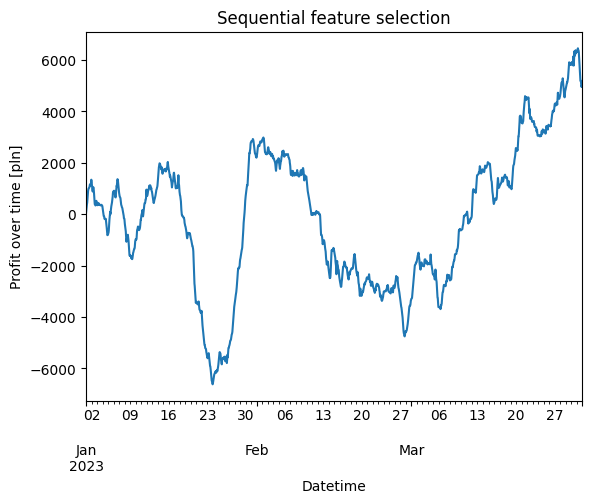

In [19]:
import matplotlib.pyplot as plt
pnls['sequential_feature_selection'].cumsum().plot()
plt.title('Sequential feature selection')
plt.xlabel('Datetime')
plt.ylabel('Profit over time [pln]')
plt.savefig('charts\exp5_test_std_sequential_feature_selection_25.png', format='png')